Задание [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), цель - предказать цену дома

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

#### Чтение данных

In [1067]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 
test_target = pd.read_csv('sample_submission.csv') # целевая переменная из test
train_target = train['SalePrice']  # целевая переменная из train
#train_target = train_target.to_frame(name='SalePrice')

In [1068]:
del train['SalePrice']

In [1069]:
all_data = train.append(test) 

In [1070]:
all_data.sample(n=5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
216,1677,120,RL,80.0,10307,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
1212,2673,120,RL,NaN,2938,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
1348,2809,80,RL,80.0,10366,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,7,2006,WD,Normal
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,...,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal
214,215,60,RL,NaN,10900,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,450,3,2010,WD,Normal


In [1071]:
for i in [train, test, train_target, test_target, all_data]:
    print(i.shape, type(i))

(1460, 80) <class 'pandas.core.frame.DataFrame'>
(1459, 80) <class 'pandas.core.frame.DataFrame'>
(1460,) <class 'pandas.core.series.Series'>
(1459, 2) <class 'pandas.core.frame.DataFrame'>
(2919, 80) <class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Плотность')

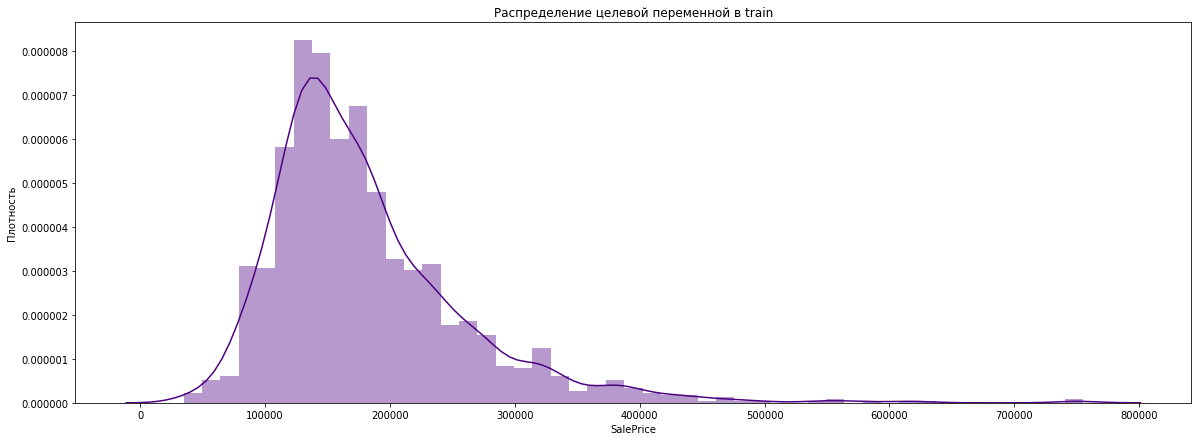

In [1072]:
plt.figure(figsize=(20,7))
sns.distplot(train_target, color='indigo')
plt.title("Распределение целевой переменной в train")
plt.ylabel("Плотность")

целевая переменная нормально распределена

ValueError: color kwarg must have one color per data set. 2 data sets and 1 colors were provided

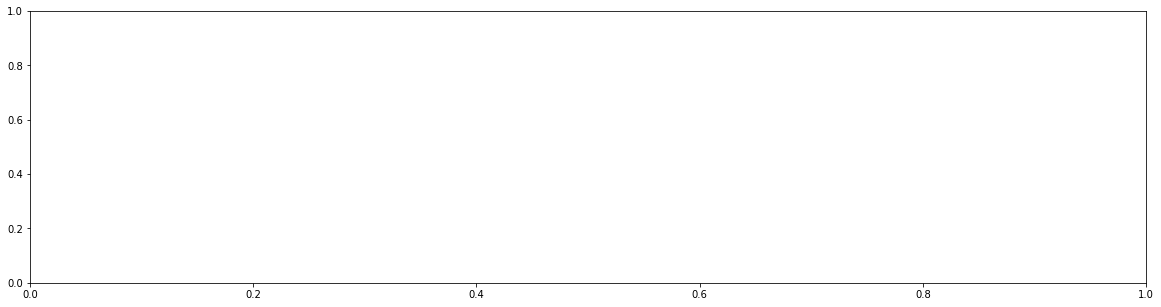

In [1073]:
plt.figure(figsize=(20,5))
sns.distplot(test_target, color='maroon')
plt.title("Распределение целевой переменной в test")
plt.ylabel("Плотность")

#### Пропущенные значения

In [1074]:
def missing_values(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : '#', 1 : '%'})
    return col

print("All data #"+str(len(all_data)))
cols = missing_values(all_data)
print(cols.sort_values(by="%", ascending=False))

All data #2919
                  #          %
PoolQC         2909  99.657417
MiscFeature    2814  96.402878
Alley          2721  93.216855
Fence          2348  80.438506
FireplaceQu    1420  48.646797
LotFrontage     486  16.649538
GarageYrBlt     159   5.447071
GarageFinish    159   5.447071
GarageQual      159   5.447071
GarageCond      159   5.447071
GarageType      157   5.378554
BsmtExposure     82   2.809181
BsmtCond         82   2.809181
BsmtQual         81   2.774923
BsmtFinType2     80   2.740665
BsmtFinType1     79   2.706406
MasVnrType       24   0.822199
MasVnrArea       23   0.787941
MSZoning          4   0.137033
Functional        2   0.068517
BsmtHalfBath      2   0.068517
BsmtFullBath      2   0.068517
Utilities         2   0.068517
GarageCars        1   0.034258
KitchenQual       1   0.034258
BsmtFinSF1        1   0.034258
SaleType          1   0.034258
BsmtFinSF2        1   0.034258
BsmtUnfSF         1   0.034258
TotalBsmtSF       1   0.034258
...             ...     

In [1075]:
# удаляем столбцы, где пропусков > 40%
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace = True)

#### Заполнение пропусков в категориальных признаках

In [1044]:
# названия столбцов с категориальными признаками
categorical_columns = all_data.columns[all_data.dtypes == 'object']

In [1076]:
from sklearn.preprocessing import LabelEncoder

for column in categorical_columns:
    all_data[column] = all_data[column].fillna(all_data[column].mode()[0])
    all_data[column] = label_encoder.fit_transform(all_data[column])[0]
#    all_data[column] = pd.factorize(all_data[column])[0]

####  Заполнение пропусков в числовых признаках

In [1077]:
# названия столбцов с числовыми признаками
cont_columns = all_data.columns[all_data.dtypes != 'object']

In [1078]:
from sklearn.preprocessing import StandardScaler #для масштабирования признаков

scaler = StandardScaler()
for column in cont_columns:
    all_data[column] = all_data[column].fillna(all_data[column].mean())
    all_data[column] = scaler.fit_transform(all_data[[column]])

In [1079]:
all_data.sample(n=5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
570,-1.055014,0.773042,0.0,0.220295,0.371927,0.0,0.0,0.0,0.0,0.0,...,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.763592,0.157646,0.0,0.0
864,1.026532,-0.873616,0.0,-0.483643,0.097378,0.0,0.0,0.0,0.0,0.0,...,-0.436428,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.815344,-0.602962,0.0,0.0
152,0.181572,-0.873616,0.0,0.000000,0.216455,0.0,0.0,0.0,0.0,0.0,...,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.078505,1.678860,0.0,0.0
1344,1.596169,-0.638379,0.0,-0.671360,-0.243241,0.0,0.0,0.0,0.0,0.0,...,-0.702843,1.524159,-0.103331,-0.285935,-0.06315,-0.089592,-0.078505,-1.363569,0.0,0.0
303,-1.371875,-0.873616,0.0,0.032578,-0.046682,0.0,0.0,0.0,0.0,0.0,...,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,0.289914,-1.363569,0.0,0.0


In [1080]:
all_data.shape

(2919, 75)

In [1081]:
train = all_data[:1460]
test  = all_data[1460:]

#### Выбираем признаки для обучения

In [1082]:
from sklearn.feature_selection import SelectKBest, f_classif

all_features = cont_columns.append(categorical_columns)

selector = SelectKBest(f_classif, len(all_features))
selector.fit(train[all_features], train_target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

print('Важность признаков:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], all_features[indices[i]]))



Важность признаков:
nan SaleCondition
nan HeatingQC
nan Foundation
nan BsmtQual
nan BsmtCond
nan BsmtExposure
nan BsmtFinType1
nan BsmtFinType2
nan Heating
nan CentralAir
nan SaleType
nan Electrical
nan KitchenQual
nan Functional
nan SaleType
nan GarageFinish
nan GarageQual
nan GarageCond
nan ExterCond
nan ExterQual
nan MasVnrType
nan Exterior2nd
nan MSZoning
nan Street
nan LotShape
nan LandContour
nan Utilities
nan LotConfig
nan LandSlope
nan Neighborhood
nan Condition1
nan Condition2
nan BldgType
nan HouseStyle
nan RoofStyle
nan RoofMatl
nan Exterior1st
nan PavedDrive
nan GarageType
nan SaleCondition
nan KitchenQual
nan CentralAir
nan HeatingQC
nan BsmtFinType2
nan Neighborhood
nan Condition1
nan Condition2
nan BldgType
nan HouseStyle
nan RoofStyle
nan RoofMatl
nan Exterior1st
nan Exterior2nd
nan MasVnrType
nan ExterQual
nan ExterCond
nan Foundation
nan BsmtQual
nan BsmtCond
nan BsmtExposure
nan Electrical
nan Heating
nan LandSlope
nan LandContour
nan PavedDrive
nan GarageCond
nan Ga

/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  2   5   6   7   8   9  10  11  12  13  14  15  20  21  22  23  24  26
  27  28  29  30  31  32  34  38  39  40  41  52  54  56  58  61  62  63
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112] are constant.
  UserWarning)
/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [1083]:
fparams = \
    ['OverallQual', 'MiscVal', 'GrLivArea', 'LotArea', 'GarageCars', 
     'FullBath', 'ExterQual', 'GarageArea', '1stFlrSF', 'TotalBsmtSF', 
     'YearBuilt', 'Foundation', 'KitchenQual', 'MasVnrArea', 'BsmtQual', 
     'TotRmsAbvGrd', 'Street', 'YearRemodAdd', 'GarageYrBlt', 'BsmtFinSF1', 
     '2ndFlrSF', 'Fireplaces', 'Heating', 'CentralAir', 'LotShape', 
     'SaleCondition', 'BsmtUnfSF', 'OpenPorchSF', 'GarageFinish', 'HalfBath', 
     'WoodDeckSF', 'HeatingQC', 'BsmtExposure', 'LandContour', 'Exterior2nd', 
     'MSZoning', 'BedroomAbvGr', 'MasVnrType', 'BsmtFinType1', 'LotFrontage', 
     'Neighborhood', 'Electrical', 'LandSlope', 'SaleType', 'BsmtFullBath', 
     'Exterior1st', 'OverallCond', 'YrSold', 'BsmtCond', 'GarageType', 
     'LotConfig', 'ScreenPorch', 'BsmtFinSF2', 'GarageQual', 'PoolArea', 
     'Condition2', 'MoSold', 'BldgType']

train_features = train[fparams].values
test_features  = test[fparams].values
train_target = train_target.values
test_target = test_target.values

In [1091]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 

params = [{'C'      : [0.1, 1.0, 2.0]},
          {'kernel' : ['linear', 'poly', 'rbf']},
          {'degree' : [1, 2, 3]},
          {'gamma'  : ['auto', 'scale']} ]

gs = GridSearchCV(SVC(gamma = 'auto'), param_grid = params, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(train_features, train_target)
print('Наилучший набор параметров модели', gs.best_estimator_, 'со значением метрики neg_mean_squared_error', gs.best_score_)           

/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Наилучший набор параметров модели SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) со значением метрики neg_mean_squared_error -2325070939.2726026


In [1090]:
from sklearn.linear_model import Lasso
lasso_regressor = Lasso()
lasso_regressor.fit(train_features, train_target)

gs = GridSearchCV(lasso_regressor, {'alpha' : [0.00001, 2, 0.001]}, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(train_features, train_target)
lasso_predictions = lasso_regressor.predict(test_features)
print("Best score", gs.best_score_)

/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7166928974.959717, tolerance: 920791133.4609975
  positive)
/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 783614753977.8582, tolerance: 759214014.2531197
  positive)
/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725491742591.4154, tolerance: 728773513.025937
  positive)
/Users/yan1/PRO/environments/py3mfti/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objecti

Best score -1422630807.9239829
